# Neutron Event Analyzer Tutorial

This tutorial demonstrates how to use the `neutron_event_analyzer` package to process and analyze neutron event camera data.

## New in v0.2.0: CSV-First Loading 🎉

The package now **prioritizes pre-exported CSV files** over empir binaries! This means:
- ✅ No empir binaries needed if you have CSV files in `ExportedEvents/` and `ExportedPhotons/` folders
- ✅ Faster loading from CSV files
- ✅ Works with both empir export format and pre-processed CSV format
- ✅ Automatic fallback to empir binaries if CSV files don't exist

## Directory Structure Options

### Option 1: Pre-exported CSV Files (Recommended)
```
data_folder/
├── photonFiles/          # Original binary files (used for matching)
│   └── *.empirphot
├── eventFiles/           # Original binary files (used for matching)
│   └── *.empirevent
├── ExportedPhotons/      # Pre-exported CSV files
│   └── *.csv
└── ExportedEvents/       # Pre-exported CSV files
    └── *.csv
```

### Option 2: empir Binaries
```
data_folder/
├── photonFiles/
│   └── *.empirphot
└── eventFiles/
    └── *.empirevent
```
Plus `export_dir` with empir binaries.

## Prerequisites

Let's import the necessary module and set up paths to the test data.

In [1]:
import neutron_event_analyzer as nea

## Step 1: Initialize the Analyser

Create an `Analyse` object. Since we have pre-exported CSV files, **no empir binaries are needed**!

The analyzer will automatically:
1. Check for CSV files in `ExportedEvents/` and `ExportedPhotons/` folders first
2. Use those CSV files if they exist
3. Only fall back to empir binaries if CSV files are missing

In [3]:
# Initialize analyzer - no export_dir needed when CSV files exist!
analyser = nea.Analyse(data_folder="../tests/data/neutrons")

## Step 2: Load Event and Photon Data

The `load()` method now automatically uses CSV files when available. It will:
- Find paired event and photon files by matching basenames
- Load from `ExportedEvents/*.csv` and `ExportedPhotons/*.csv` if they exist
- Fall back to empir conversion if CSV files are missing

You can also use optional parameters:
- `query`: Filter events (e.g., `"n > 2"` for multi-photon events only)
- `limit`: Limit number of rows loaded

In [4]:
# Load data - will automatically use CSV files from ExportedEvents/ExportedPhotons
# Using explicit glob patterns to match the test data files
analyser.load()

print(f"\n✓ Loaded {len(analyser.events_df)} events and {len(analyser.photons_df)} photons")
print(f"\nEvent DataFrame columns: {list(analyser.events_df.columns)}")
print(f"Photon DataFrame columns: {list(analyser.photons_df.columns)}")

# Show first few events
print("\nFirst 5 events:")
analyser.events_df.head()

Found 6 paired files.


2025-12-30 11:04:08,890 - Using existing CSV: ../tests/data/neutrons/ExportedEvents/traced_data_0_part002.csv
2025-12-30 11:04:08,889 - Using existing CSV: ../tests/data/neutrons/ExportedEvents/traced_data_0_part001.csv
2025-12-30 11:04:08,890 - Using existing CSV: ../tests/data/neutrons/ExportedEvents/traced_data_0_part003.csv


Loading pairs:   0%|          | 0/6 [00:00<?, ?it/s]

2025-12-30 11:04:08,890 - Using existing CSV: ../tests/data/neutrons/ExportedEvents/traced_data_0_part005.csv
2025-12-30 11:04:08,890 - Using existing CSV: ../tests/data/neutrons/ExportedEvents/traced_data_0_part004.csv
2025-12-30 11:04:08,891 - Using existing CSV: ../tests/data/neutrons/ExportedEvents/traced_data_0_part006.csv
2025-12-30 11:04:08,910 - Using existing CSV: ../tests/data/neutrons/ExportedPhotons/traced_data_0_part005.csv
2025-12-30 11:04:08,911 - Using existing CSV: ../tests/data/neutrons/ExportedPhotons/traced_data_0_part006.csv
2025-12-30 11:04:08,911 - Using existing CSV: ../tests/data/neutrons/ExportedPhotons/traced_data_0_part002.csv
2025-12-30 11:04:08,912 - Using existing CSV: ../tests/data/neutrons/ExportedPhotons/traced_data_0_part004.csv
2025-12-30 11:04:08,913 - Using existing CSV: ../tests/data/neutrons/ExportedPhotons/traced_data_0_part001.csv
2025-12-30 11:04:08,913 - Using existing CSV: ../tests/data/neutrons/ExportedPhotons/traced_data_0_part003.csv


Loaded 1004 events and 1062 photons in total.

✓ Loaded 1004 events and 1062 photons

Event DataFrame columns: ['x', 'y', 't', 'n', 'PSD', 'tof']
Photon DataFrame columns: ['x', 'y', 't', 'tof']

First 5 events:


,x,y,t,n,PSD,tof
0,65.85,109.62,0.005120,1.0,0.0,3.671875e-07
1,40.00,87.00,0.005120,1.0,0.0,3.718750e-07
2,68.12,105.88,0.005120,1.0,0.0,3.718750e-07
3,88.00,123.00,0.005126,1.0,0.0,5.750000e-07
4,58.00,125.00,0.005130,1.0,0.0,2.640625e-07


## Step 3: Associate Photons to Events

Associate photons to events using one of several methods:
- `'simple'`: Fast forward time-window method (recommended for small datasets)
- `'kdtree'`: Full KDTree-based association
- `'window'`: Time-window KDTree (efficient for time-sorted data)
- `'lumacam'`: Uses lumacamTesting library (requires optional installation)
- `'auto'`: Automatically selects best method

Parameters:
- `dSpace_px`: Maximum spatial distance for photon-event matching
- `max_time_ns`: Maximum time window in nanoseconds
- `method`: Association method to use

In [9]:
# Perform association using the simple method (fast for small datasets)
analyser.associate(
    method='auto',
    dSpace_px=50,
    max_time_ns=500,
    verbosity=1
)

print(f"\n✓ Association complete!")
print(f"Associated {len(analyser.associated_df)} photons")

Associating pairs:   0%|          | 0/6 [00:00<?, ?it/s]

2025-12-30 11:04:41,821 - Before grouping: 1055 photons with non-NaN assoc_x
2025-12-30 11:04:41,829 - After grouping: 1055 photons with non-NaN assoc_event_id


✅ Matched 1055 of 1062 photons (99.3%)

✓ Association complete!
Associated 1062 photons


In [10]:
# View associated photons (non-NaN entries have been matched to events)
print("Associated photons (showing matched entries):")
analyser.associated_df.dropna(subset=['assoc_event_id']).head(10)

Associated photons (showing matched entries):


,x,y,t,tof,assoc_event_id,assoc_x,assoc_y,assoc_t,assoc_n,assoc_PSD,time_diff_ns,spatial_diff_px,assoc_com_dist,assoc_status
0,66.67,172.67,0.006600,2.984375e-07,244.0,66.67,172.67,0.006600,1,0.0,0.0,0.000000,0.0,cog_match
1,46.84,172.98,0.006600,3.015625e-07,152.0,46.42,173.24,0.006600,2,0.0,0.0,0.493964,0.0,cog_match
2,46.00,173.50,0.006600,3.015625e-07,152.0,46.42,173.24,0.006600,2,0.0,0.0,0.493964,0.0,cog_match
3,96.12,147.12,0.006600,3.046875e-07,365.0,96.12,147.12,0.006600,1,0.0,0.0,0.000000,0.0,cog_match
4,98.00,184.00,0.006616,5.640625e-07,377.0,98.00,184.00,0.006616,1,0.0,0.0,0.000000,0.0,cog_match
5,165.84,144.18,0.006635,3.250000e-07,665.0,165.84,144.18,0.006635,1,0.0,0.0,0.000000,0.0,cog_match
6,168.12,138.88,0.006635,3.359375e-07,675.0,168.12,138.88,0.006635,1,0.0,0.0,0.000000,0.0,cog_match
7,184.00,7.00,0.006661,6.109375e-07,737.0,184.00,7.00,0.006661,1,0.0,0.0,0.000000,0.0,cog_match
8,1.00,153.91,0.006665,5.253125e-06,9.0,1.00,153.91,0.006665,1,0.0,0.0,0.000000,0.0,cog_match
9,170.00,188.00,0.006676,7.656250e-07,683.0,170.00,188.00,0.006676,1,0.0,0.0,0.000000,0.0,cog_match


## Step 5: Retrieve Combined DataFrame

Get the complete DataFrame with all photon, event, and shape data.

In [11]:
# Get the complete associated DataFrame
combined_df = analyser.get_combined_dataframe()

print(f"Combined DataFrame shape: {combined_df.shape}")
print(f"Columns: {list(combined_df.columns)}")

# Show summary statistics
print("\nAssociation Summary:")
matched = combined_df['assoc_event_id'].notna().sum()
total = len(combined_df)
print(f"  Matched photons: {matched}/{total} ({100*matched/total:.1f}%)")
print(f"  Unique events: {combined_df['assoc_event_id'].nunique()}")

# Display sample
print("\nSample of combined data:")
combined_df.dropna(subset=['assoc_event_id']).head()

Combined DataFrame shape: (1062, 14)
Columns: ['x', 'y', 't', 'tof', 'assoc_event_id', 'assoc_x', 'assoc_y', 'assoc_t', 'assoc_n', 'assoc_PSD', 'time_diff_ns', 'spatial_diff_px', 'assoc_com_dist', 'assoc_status']

Association Summary:
  Matched photons: 1055/1062 (99.3%)
  Unique events: 1004

Sample of combined data:


,x,y,t,tof,assoc_event_id,assoc_x,assoc_y,assoc_t,assoc_n,assoc_PSD,time_diff_ns,spatial_diff_px,assoc_com_dist,assoc_status
0,66.67,172.67,0.006600,2.984375e-07,244.0,66.67,172.67,0.006600,1,0.0,0.0,0.000000,0.0,cog_match
1,46.84,172.98,0.006600,3.015625e-07,152.0,46.42,173.24,0.006600,2,0.0,0.0,0.493964,0.0,cog_match
2,46.00,173.50,0.006600,3.015625e-07,152.0,46.42,173.24,0.006600,2,0.0,0.0,0.493964,0.0,cog_match
3,96.12,147.12,0.006600,3.046875e-07,365.0,96.12,147.12,0.006600,1,0.0,0.0,0.000000,0.0,cog_match
4,98.00,184.00,0.006616,5.640625e-07,377.0,98.00,184.00,0.006616,1,0.0,0.0,0.000000,0.0,cog_match


## Step 7: Plot a Specific Event

Visualize individual events to see their associated photons and event center.

Plotting event 604.0


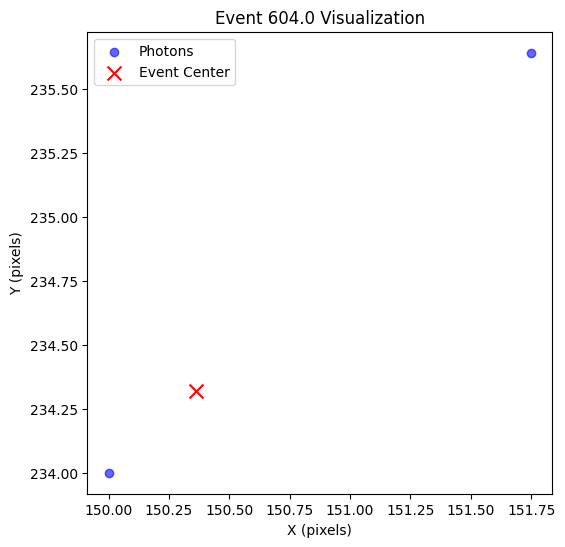

In [14]:
# Find an interesting event (e.g., multi-photon event)
multi_photon_events = combined_df.query("assoc_n > 2")['assoc_event_id'].dropna().unique()

if len(multi_photon_events) > 0:
    event_id = multi_photon_events[0]
    print(f"Plotting event {event_id}")
    analyser.plot_event(event_id=event_id, title=f'Event {event_id} Visualization')
else:
    print("No multi-photon events found. Showing first event instead.")
    event_id = combined_df['assoc_event_id'].dropna().iloc[0]
    analyser.plot_event(event_id=event_id, title=f'Event {event_id} Visualization')

## Advanced Features

### Query Filtering
You can filter events during loading:
```python
# Load only multi-photon events
analyser.load(query="n > 2")
```

### Row Limiting
Limit data for quick tests:
```python
# Load only first 1000 rows
analyser.load(limit=1000)
```

### Multiple Association Methods
Try different methods for best results:
```python
# KDTree (full space-time search)
analyser.associate(method='kdtree', time_norm_ns=1, spatial_norm_px=5, dSpace_px=50)

# Window (efficient for sorted data)
analyser.associate(method='window', time_norm_ns=1, spatial_norm_px=5, dSpace_px=50, max_time_ns=500)

# Simple (fastest for small windows)
analyser.associate(method='simple', dSpace_px=50, max_time_ns=500)
```

## Notes

- **CSV Files**: Pre-exported CSV files in `ExportedEvents/` and `ExportedPhotons/` are used automatically
- **empir Binaries**: Only needed if CSV files don't exist (will fall back automatically)
- **File Matching**: CSV filenames must match binary file basenames (e.g., `data_001.empirevent` → `data_001.csv`)
- **Flexible Format**: Works with both empir export format and pre-processed CSV format
- **Performance**: Loading from CSV is faster than converting with empir binaries
- **Multithreading**: Adjust `n_threads` based on your system (default: 10)

## What's New in v0.2.0

✨ **CSV-First Loading**: No more mandatory empir dependency!
✨ **Flexible Format Support**: Handles both empir export and custom CSV formats
✨ **Better Error Messages**: Clear feedback when files are missing
✨ **Query Filtering**: Filter events during load with pandas query syntax
✨ **Row Limiting**: Quick testing with subset of data

For more details, see the [README](../README.md) and [test documentation](../tests/README.md).